# Diffusion model for clutter denoising

## Initialization

### Imports

In [1]:
import os
import math
import torch
import wandb
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch import einsum
from models.unet import *
import torch.optim as optim
from utils.trainer import *
from models.newdif import *
from torch.optim import Adam
from utils.plotters import *
from utils.inference import *
#from models.diffusion import *
from dataset.radardata import *
import torch.nn.functional as F
import matplotlib.pyplot as plt
from types import SimpleNamespace
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split

### Define device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Initialiaze W&B + config

In [3]:
wandb.init(
    project="Radar-diffusion",
    name="exp_8",
    notes="new soft loss",
    config={
        "SNR": 10,
        "CNR": 15,
        "max_lr": 1e-3,
        "beta_end": 0.02,
        "final_lr": 1e-5,
        "num_heads": 8,
        "beta_start": 1e-4,
        "num_layers": 6,
        "batch_size": 16,
        "num_epochs": 400,
        "noise_steps": 2000,
        "num_workers": 4,
        "weight_decay": 1e-4,
        "warmup_steps": 4000,
        "dataset_size": 50000,
        "time_emb_dim": 256,
        "learning_rate": 1e-4,        
        "scheduler_type": "linear",
    },
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ari-granevich. Use `wandb login --relogin` to force relogin


## dataset prep

In [4]:
train_loader, val_loader, norm_train_loader, norm_val_loader, train_dataset_with_targets, norm_train_dataset, norm_val_dataset = prep_dataset(config)

Normalizing dataset: 100%|██████████| 5500/5500 [00:09<00:00, 596.51it/s] 


## Dataset Visualization

In [5]:
# visualize_sample(train_dataset_with_targets, sample_index=1, plot_here=False, save_to_wandb=True) # regular dataset.
# visualize_sample(norm_train_dataset, sample_index=1, plot_here=False, save_to_wandb=True) # same dataset, after normalization.
# compare_nu_scnr(nu_values=[0.01, 0.1, 1], scnr_values=[-20, -10, 0, 10, 20], radar_dataset_class=RadarDataset, plot_here=False, save_to_wandb=True)

## train

In [6]:
train_loader = norm_train_loader
val_loader = norm_val_loader
cond_unet = ConditionalUNet(in_channels=4, out_channels=2, time_emb_dim=config.time_emb_dim).to(device)
cond_diffusion = ConditionalDiffusion(model=cond_unet, scheduler_type=config.scheduler_type, T=config.noise_steps, 
    beta_start=config.beta_start, beta_end=config.beta_end).to(device)
optimizer = torch.optim.Adam(cond_diffusion.parameters(), config.learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=1e-4, cooldown=15, min_lr=1e-6, verbose=True)
num_epochs = config.num_epochs

/home/hawk/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
best_val_loss = float('inf')
best_mse_loss = float('inf')
train_losses, val_losses, val_psnrs, val_mses = [], [], [], []

for epoch in range(num_epochs):
    train_loss, e_mse_loss, e_rd_loss= train_one_epoch(cond_diffusion, train_loader, optimizer, device)
    val_loss, iq_val_loss, rd_val_loss, gen_mse, gen_psnr, rd_mse = validate(cond_diffusion, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if gen_psnr is not None:
        val_psnrs.append(gen_psnr)
    if gen_mse is not None:
        val_mses.append(gen_mse)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")

    if gen_mse is not None and gen_psnr is not None:
        print(f"   [Generation Metrics] MSE: {gen_mse:.4f} | PSNR: {gen_psnr:.2f} dB")

    #scheduler.step(val_loss)

    if gen_mse < best_mse_loss:
        best_mse_loss = gen_mse
        torch.save(cond_diffusion.state_dict(), "exp_8_MSE.pth")
        print("   --> Best MSE model saved.")

    # if val_loss < best_val_loss:
    #     best_mse_loss = val_loss
    #     torch.save(cond_diffusion.state_dict(), "exp_3_VAL.pth")
    #     print("   --> Best VAL model saved.")

    wandb.log({
        "total train loss": train_loss,
        "train mse loss": e_mse_loss,
        "train rd loss": e_rd_loss,
        "total val loss": val_loss,
        "IQ val loss": iq_val_loss, 
        "RD val loss": rd_val_loss,
        "MSE between denoised RD and clean RD": rd_mse,
        "MSE between denoised IQ and clean IQ": gen_mse if gen_mse is not None else float('nan'),
        "generated IQ map PSNR": gen_psnr,
        "learning rate": optimizer.param_groups[0]['lr']  # Optional, log current LR
    })


Epoch 1/400: Train Loss = 5.5172 | Val Loss = 5.1079
   [Generation Metrics] MSE: 27179.3086 | PSNR: -32.57 dB
   --> Best MSE model saved.
Epoch 2/400: Train Loss = 4.9444 | Val Loss = 4.6570
   [Generation Metrics] MSE: 95306.3438 | PSNR: -38.02 dB
Epoch 3/400: Train Loss = 4.7510 | Val Loss = 4.5773
   [Generation Metrics] MSE: 300.5658 | PSNR: -13.01 dB
   --> Best MSE model saved.
Epoch 4/400: Train Loss = 4.5294 | Val Loss = 4.4273
   [Generation Metrics] MSE: 2568.2041 | PSNR: -22.33 dB
Epoch 5/400: Train Loss = 4.4870 | Val Loss = 4.8196
   [Generation Metrics] MSE: 439219.8125 | PSNR: -44.66 dB
Epoch 6/400: Train Loss = 4.3876 | Val Loss = 4.2875
   [Generation Metrics] MSE: 657.8453 | PSNR: -16.41 dB
Epoch 7/400: Train Loss = 4.2655 | Val Loss = 4.2074
   [Generation Metrics] MSE: 22154.5098 | PSNR: -31.69 dB
Epoch 8/400: Train Loss = 4.2277 | Val Loss = 4.4066
   [Generation Metrics] MSE: 3497.4539 | PSNR: -23.67 dB
Epoch 9/400: Train Loss = 4.1508 | Val Loss = 4.0502
   [Ge

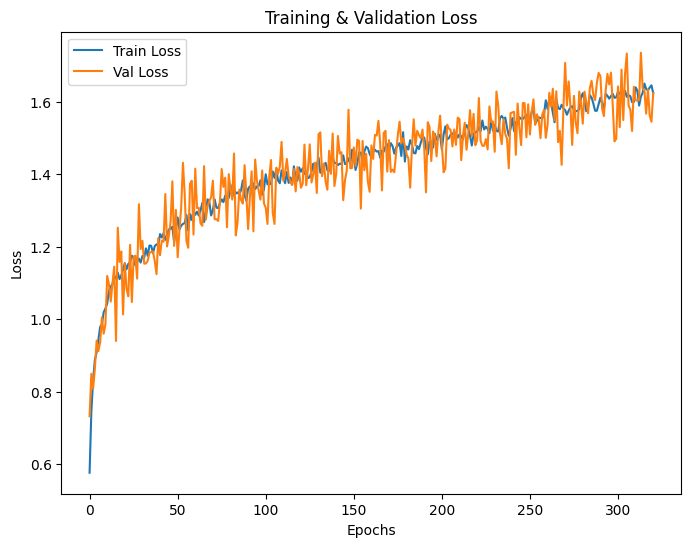

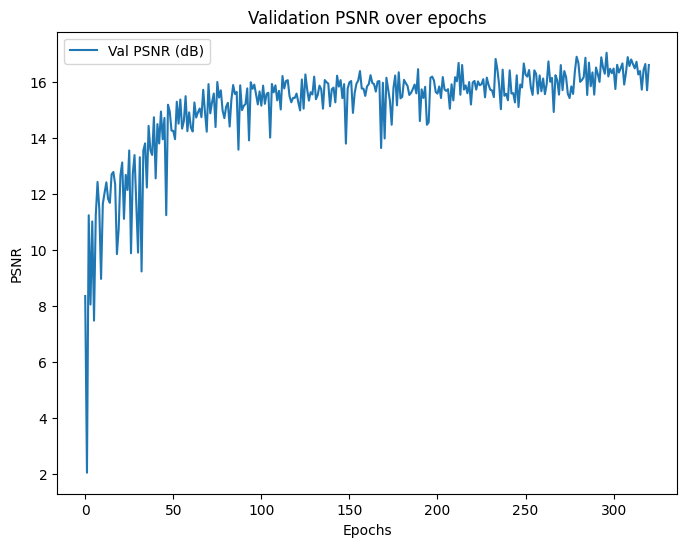

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

if len(val_psnrs) > 0:
    plt.figure(figsize=(8,6))
    plt.plot(val_psnrs, label="Val PSNR (dB)")
    plt.xlabel("Epochs")
    plt.ylabel("PSNR")
    plt.title("Validation PSNR over epochs")
    plt.legend()
    plt.show()

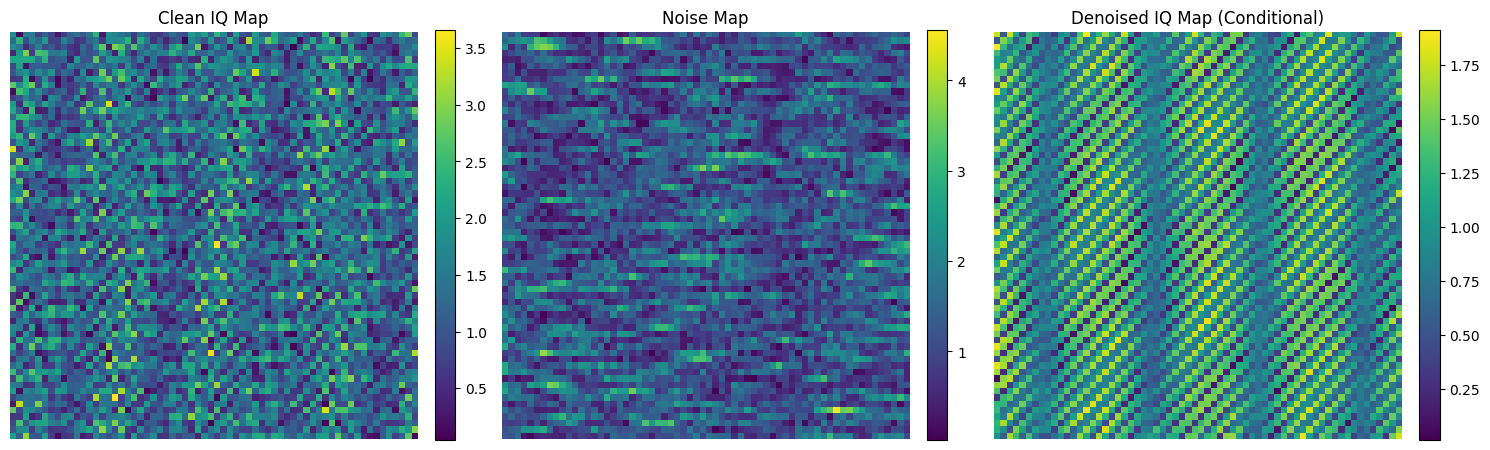

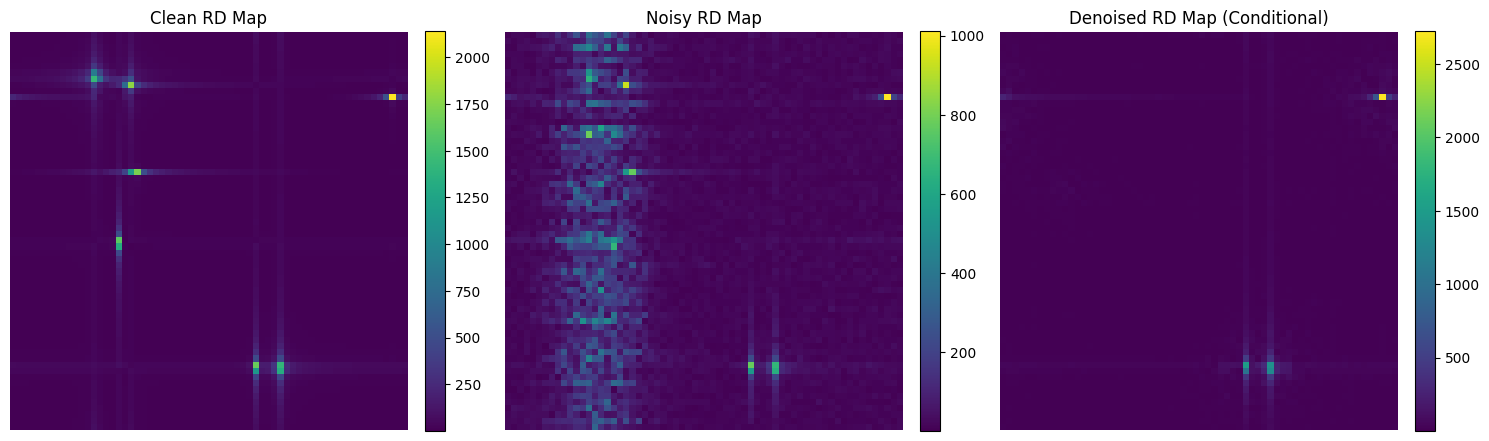

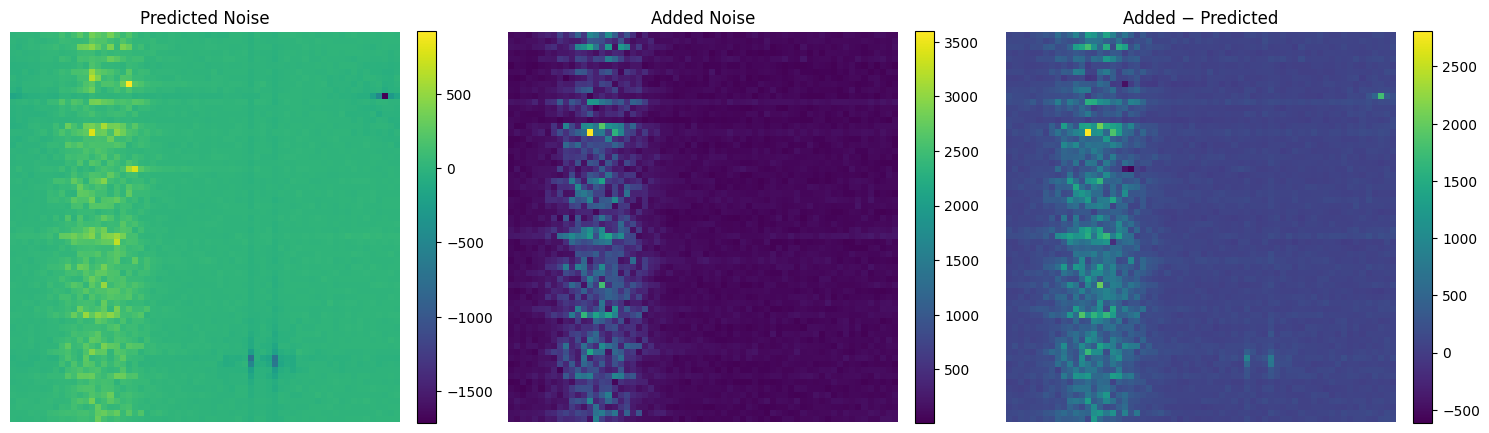

In [ ]:
run_inference(cond_diffusion , norm_val_dataset, '/home/hawk/Desktop/Heavy Detector/Heavy-Clutter-Detection/finalDiffusion/exp_6_MSE.pth', device)